# 🎓 Notebook 10: Visualizing the Vector Space

Humans can only see in 3D, but our AI embeddings live in **1,536 dimensions**. How can we understand what the AI is "seeing"? 

In this notebook, we use **Principal Component Analysis (PCA)** to squash those dimensions into a 3D plot, allowing us to see semantic clusters visually.

### Learning Objectives:
1. Understand Dimensionality Reduction.
2. Visualize document clusters in 3D.
3. See how the "Query Vector" lands near relevant context.

In [1]:
import sys
import os

root = os.getcwd()
rag_root = None

while True:
    candidate = os.path.join(root, 'sprints', 'rag_engine', 'rag-engine-mini')
    if os.path.isdir(os.path.join(candidate, 'src')):
        rag_root = candidate
        break
    if os.path.basename(root) == 'rag-engine-mini' and os.path.isdir(os.path.join(root, 'src')):
        rag_root = root
        break
    parent = os.path.dirname(root)
    if parent == root:
        break
    root = parent

if rag_root:
    sys.path.insert(0, rag_root)


In [2]:
import os
import numpy as np
from src.core.bootstrap import get_container

container = get_container()

if not os.getenv("OPENAI_API_KEY"):
    class DummyEmbedder:
        def embed_one(self, text: str):
            seed = abs(hash(text)) % (2**32)
            rng = np.random.default_rng(seed)
            return rng.normal(size=64).tolist()

    print("OPENAI_API_KEY not set; using dummy embeddings for demo.")
    embedder = DummyEmbedder()
else:
    embedder = container["embeddings"]


OPENAI_API_KEY not set; using dummy embeddings for demo.


## 1. Generating Sample Data

We'll create three distinct "semantic islands": Space, Cooking, and Programming.

In [3]:
categories = {
    "Space": ["The moon orbits the earth", "Mars is the red planet", "Supernova explosion", "Astronauts in orbit"],
    "Cooking": ["Bake the cake at 350 degrees", "Add two eggs and sugar", "Whisk the cream until stiff", "Chocolate chip cookie recipe"],
    "Programming": ["Python is a dynamic language", "Git commit and push changes", "Debug the recursive function", "Docker container orchestration"]
}

texts = []
labels = []
for cat, sents in categories.items():
    texts.extend(sents)
    labels.extend([cat] * len(sents))

embeddings = [embedder.embed_one(t) for t in texts]
embeddings_array = np.array(embeddings)

## 2. PCA Reduction

PCA finds the directions (components) that capture the most variance in the data.

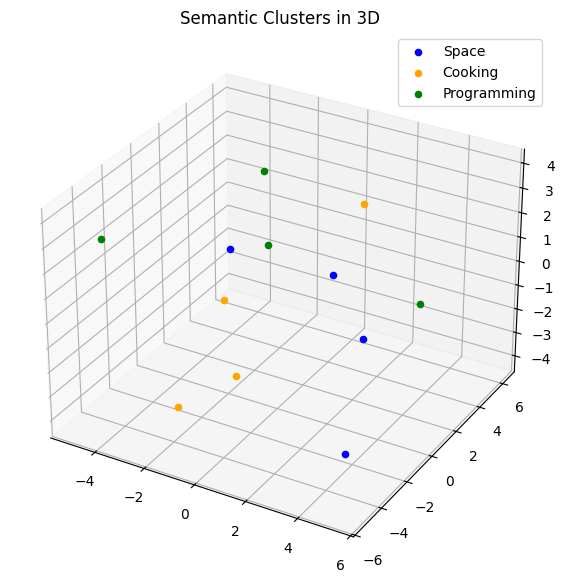

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=3)
reduced_vectors = pca.fit_transform(embeddings_array)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

colors = {'Space': 'blue', 'Cooking': 'orange', 'Programming': 'green'}

for i, label in enumerate(labels):
    ax.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], reduced_vectors[i, 2], 
               c=colors[label], label=label if i % 4 == 0 else "")

ax.set_title("Semantic Clusters in 3D")
plt.legend()
plt.show()


## 3. The RAG Search Moment

Let's see where a new question lands in this space!

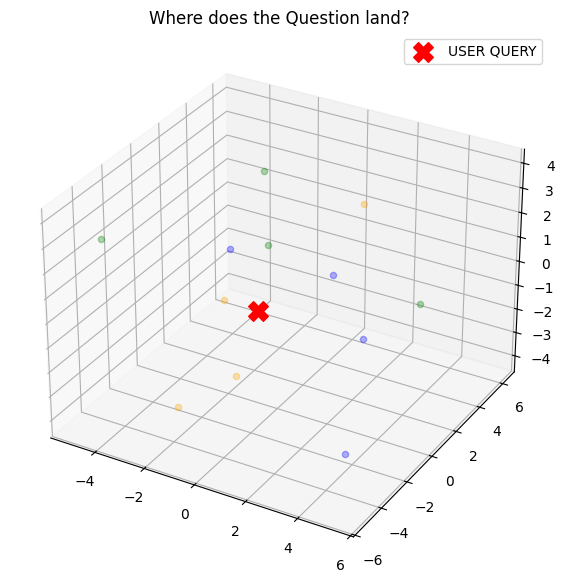

Notice how the red 'X' lands near the 'Programming' (green) cluster!


In [5]:
query = "How do I fix a bug in my code?"
query_vec = embedder.embed_one(query)
reduced_query = pca.transform([query_vec])

# Re-plot with the query
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for i, label in enumerate(labels):
    ax.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], reduced_vectors[i, 2], 
               c=colors[label], alpha=0.3)

ax.scatter(reduced_query[0, 0], reduced_query[0, 1], reduced_query[0, 2], 
           c='red', marker='X', s=200, label='USER QUERY')

ax.set_title("Where does the Question land?")
plt.legend()
plt.show()

print("Notice how the red 'X' lands near the 'Programming' (green) cluster!")

---
**Congratulations!** You now have visual proof of why RAG works. The AI isn't just searching for keywords; it's navigating a geometric landscape of meaning.